# Parking Occupancy Model Training
Train and evaluate a regression model that forecasts hourly parking occupancy by street using preprocessed features.

## Set Up Environment
Import core libraries, configure paths, and ensure deterministic behavior across runs.

In [1]:
# Imports and configuration
from pathlib import Path
import json
import joblib
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 100)

BASE_DIR = Path("..").resolve()
PROCESSED_DIR = BASE_DIR / "data" / "processed"
ARTIFACT_DIR = BASE_DIR / "models" / "occupancy"
MODEL_PATH = ARTIFACT_DIR / "lightgbm_parking_occupancy.txt"
METRICS_PATH = ARTIFACT_DIR / "model_metrics.json"
FEATURE_IMPORTANCE_PATH = ARTIFACT_DIR / "feature_importance.csv"

PROCESSED_DIR.mkdir(parents=True, exist_ok=True)
ARTIFACT_DIR.mkdir(parents=True, exist_ok=True)

MODEL_PATH, METRICS_PATH, FEATURE_IMPORTANCE_PATH

(PosixPath('/Users/philipt/ArlingtonParkingPredict/models/occupancy/lightgbm_parking_occupancy.txt'),
 PosixPath('/Users/philipt/ArlingtonParkingPredict/models/occupancy/model_metrics.json'),
 PosixPath('/Users/philipt/ArlingtonParkingPredict/models/occupancy/feature_importance.csv'))

## Load Processed Datasets
Load train, validation, and test splits generated during preprocessing.

In [2]:
train_path = PROCESSED_DIR / "occupancy_train.parquet"
val_path = PROCESSED_DIR / "occupancy_val.parquet"
test_path = PROCESSED_DIR / "occupancy_test.parquet"
metadata_path = ARTIFACT_DIR / "preprocessing_metadata.json"
pipeline_path = ARTIFACT_DIR / "preprocessing_pipeline.joblib"

for path in [train_path, val_path, test_path]:
    if not path.exists():
        raise FileNotFoundError(f"Missing processed dataset: {path}")

train_df = pd.read_parquet(train_path)
val_df = pd.read_parquet(val_path)
test_df = pd.read_parquet(test_path)

with metadata_path.open() as fh:
    preprocessing_metadata = json.load(fh)
preprocessing_pipeline = joblib.load(pipeline_path)

train_df.head()

,street,day_of_week,hour_of_day,month,is_weekend,hour_sin,hour_cos,occupancy
0,0.445696,-0.324792,0.512040,-1.250139,-0.441732,-0.953504,-0.200632,59
1,0.445696,-1.521257,1.354831,-1.250139,-0.441732,-0.953504,1.546199,32
2,-1.316821,1.469906,-0.752148,-1.250139,2.263818,1.013203,-0.840016,2
3,-0.422005,-1.521257,-0.541450,0.651905,-0.441732,0.665968,-1.014525,11
4,-1.343937,-1.521257,-0.962846,-1.250139,-0.441732,1.311381,-0.562412,30


## Inspect Split Shapes
Confirm dataset sizes and target distribution prior to training.

In [3]:
def summarize_split(name: str, frame: pd.DataFrame) -> None:
    print(f"{name}: {len(frame):,} rows | {frame.shape[1]} columns")
    print("Target stats:")
    print(frame['occupancy'].describe(percentiles=[0.5, 0.75, 0.9, 0.95]))
    print("-")

summarize_split("Train", train_df)
summarize_split("Validation", val_df)
summarize_split("Test", test_df)

Train: 108,692 rows | 8 columns
Target stats:
count    108692.000000
mean         20.129559
std          36.090209
min           1.000000
50%           8.000000
75%          21.000000
90%          49.000000
95%          77.000000
max         499.000000
Name: occupancy, dtype: float64
-
Validation: 23,296 rows | 8 columns
Target stats:
count    23296.000000
mean        20.127919
std         35.928506
min          1.000000
50%          8.000000
75%         21.000000
90%         50.000000
95%         77.000000
max        364.000000
Name: occupancy, dtype: float64
-
Test: 23,293 rows | 8 columns
Target stats:
count    23293.000000
mean        20.172627
std         36.280094
min          1.000000
50%          8.000000
75%         21.000000
90%         49.000000
95%         78.000000
max        355.000000
Name: occupancy, dtype: float64
-


## Prepare Feature Matrices
Separate features from the target column and confirm shapes for LightGBM.

In [4]:
feature_columns = [col for col in train_df.columns if col != "occupancy"]
target_column = "occupancy"

X_train = train_df[feature_columns]
y_train = train_df[target_column]
X_val = val_df[feature_columns]
y_val = val_df[target_column]
X_test = test_df[feature_columns]
y_test = test_df[target_column]

X_train.shape, X_val.shape, X_test.shape

((108692, 7), (23296, 7), (23293, 7))

## Train LightGBM Regressor
Fit a gradient boosting model with early stopping based on validation RMSE.

In [5]:
lgb_train = lgb.Dataset(X_train, label=y_train)
lgb_val = lgb.Dataset(X_val, label=y_val, reference=lgb_train)

params = {
    "objective": "poisson",
    "metric": "rmse",
    "learning_rate": 0.05,
    "num_leaves": 63,
    "feature_fraction": 0.8,
    "bagging_fraction": 0.8,
    "bagging_freq": 5,
    "min_data_in_leaf": 20,
    "force_col_wise": True,
    "seed": 2025,
}

callbacks = [
    lgb.log_evaluation(period=50),
    lgb.early_stopping(stopping_rounds=50),
]

booster = lgb.train(
    params,
    lgb_train,
    num_boost_round=1000,
    valid_sets=[lgb_train, lgb_val],
    valid_names=["train", "val"],
    callbacks=callbacks,
 )

[LightGBM] [Info] Total Bins 215
[LightGBM] [Info] Number of data points in the train set: 108692, number of used features: 7
[LightGBM] [Info] Start training from score 3.002189
Training until validation scores don't improve for 50 rounds
[50]	train's rmse: 16.158	val's rmse: 15.9587
[100]	train's rmse: 10.8105	val's rmse: 10.6493
[150]	train's rmse: 8.89378	val's rmse: 8.78185
[200]	train's rmse: 8.07808	val's rmse: 8.00943
[250]	train's rmse: 7.63841	val's rmse: 7.60333
[300]	train's rmse: 7.34573	val's rmse: 7.33306
[350]	train's rmse: 7.13226	val's rmse: 7.1487
[400]	train's rmse: 6.99008	val's rmse: 7.02757
[450]	train's rmse: 6.85875	val's rmse: 6.91002
[500]	train's rmse: 6.75876	val's rmse: 6.83985
[550]	train's rmse: 6.69583	val's rmse: 6.79018
[600]	train's rmse: 6.62703	val's rmse: 6.74129
[650]	train's rmse: 6.56468	val's rmse: 6.70537
[700]	train's rmse: 6.5168	val's rmse: 6.67445
[750]	train's rmse: 6.46446	val's rmse: 6.64237
[800]	train's rmse: 6.43072	val's rmse: 6.62

## Evaluate Model
Compute RMSE and MAE on validation and test splits.

In [6]:
def compute_metrics(y_true, y_pred):
    rmse = float(np.sqrt(mean_squared_error(y_true, y_pred)))
    mae = float(mean_absolute_error(y_true, y_pred))
    return {"rmse": rmse, "mae": mae}

val_pred = booster.predict(X_val, num_iteration=booster.best_iteration)
test_pred = booster.predict(X_test, num_iteration=booster.best_iteration)

val_metrics = compute_metrics(y_val, val_pred)
test_metrics = compute_metrics(y_test, test_pred)

print("Validation:", val_metrics)
print("Test:", test_metrics)

Validation: {'rmse': 6.566567328113227, 'mae': 3.462467263324674}
Test: {'rmse': 6.433329604193607, 'mae': 3.489848317544653}


## Inspect Feature Importance
Visualize gain-based importances to understand driver features.

In [7]:
importance_df = pd.DataFrame({
    "feature": feature_columns,
    "gain": booster.feature_importance(importance_type="gain"),
    "split": booster.feature_importance(importance_type="split"),
})
importance_df = importance_df.sort_values("gain", ascending=False)
importance_df.head(10)

,feature,gain,split
0,street,2.275716e+07,28504
2,hour_of_day,4.429607e+06,11955
6,hour_cos,9.246219e+05,3238
1,day_of_week,5.091610e+05,8428
5,hour_sin,3.440760e+05,3852
4,is_weekend,1.499950e+05,760
3,month,6.233925e+04,5263


/var/folders/4s/_79x00ln3433_t94ty28vgl00000gn/T/ipykernel_85957/3763266876.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importance_df.head(10), x="gain", y="feature", palette="Blues_r")


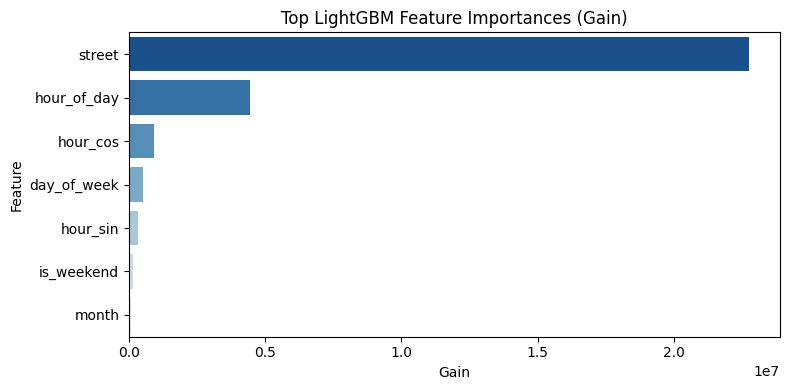

In [8]:
plt.figure(figsize=(8, 4))
sns.barplot(data=importance_df.head(10), x="gain", y="feature", palette="Blues_r")
plt.title("Top LightGBM Feature Importances (Gain)")
plt.xlabel("Gain")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

## Persist Artifacts
Save the trained LightGBM model, metrics, and feature importance for downstream use.

In [ ]:
booster.save_model(str(MODEL_PATH))
importance_df.to_csv(FEATURE_IMPORTANCE_PATH, index=False)

metrics_payload = {
    "validation": val_metrics,
    "test": test_metrics,
    "best_iteration": int(booster.best_iteration),
    "preprocessing": preprocessing_metadata,
}
with METRICS_PATH.open("w", encoding="utf-8") as fh:
    json.dump(metrics_payload, fh, indent=2)

MODEL_PATH, METRICS_PATH, FEATURE_IMPORTANCE_PATH

## Next Steps
- Integrate the trained model into the Streamlit UI for live occupancy forecasts.
- Schedule periodic re-training as new months of data become available.
- Explore additional covariates (events, weather) to further reduce RMSE.